In [1]:
import numpy as np
import pandas as pd

import tqdm
from tqdm import tqdm_notebook
import re

from functools import reduce

from matplotlib import pyplot as plt
import matplotlib
%pylab inline

import nltk
from nltk import sent_tokenize, word_tokenize
from nltk.stem import SnowballStemmer 
from nltk.corpus import stopwords
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.feature_extraction.text import TfidfVectorizer

import pymorphy2 as pm
morph = pm.MorphAnalyzer()

import xgboost as xgb
from sklearn.model_selection import train_test_split

import ast
import string
from sklearn.metrics.pairwise import paired_cosine_distances

Populating the interactive namespace from numpy and matplotlib


C:\Users\PDudukin\Anaconda3\lib\site-packages\sklearn\cross_validation.py:44: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


In [29]:
train_ds, test_ds = pd.read_csv('train_task1_latest.csv', encoding ='utf-8'), pd.read_csv('test_task1_latest.csv', encoding ='utf-8')
qnonsense_df = pd.read_csv('qnonsense_df.csv', encoding ='utf-8', index_col = 0)

In [30]:
train_ds = pd.concat([train_ds, qnonsense_df], ignore_index = True)

In [31]:
# columns = ['num_related_pars', - ok
#           'score', - ok
#           'best_score', - ok 
#           'len_question', - ok
#           'len_percent', - ok
#           'num_sentences',
#           'unq_qwords_rate', - ok
#           'min_sent_score', - ok
#           'token_set_ratio', - ok
#           'diff_score', - ok
#           'cos_dist']

## len_question

In [32]:
train_ds['len_question'] = train_ds['question'].map(lambda x: len(list(x.split(' '))))
test_ds['len_question'] = test_ds['question'].map(lambda x: len(list(x.split(' '))))

## num_pars/ques

In [33]:
train_ds['num_related_pars'] = train_ds.groupby(['question_id'])['paragraph_id'].transform('count')
train_ds['num_related_ques'] = train_ds.groupby(['paragraph_id'])['question_id'].transform('count')

test_ds['num_related_pars'] = test_ds.groupby(['question_id'])['paragraph_id'].transform('count')
test_ds['num_related_ques'] = test_ds.groupby(['paragraph_id'])['question_id'].transform('count')

In [34]:
train_ds.head()

,paragraph_id,question_id,paragraph,question,target,len_question,num_related_pars,num_related_ques
0,1094,46273,"В отличие от рыб, земноводные (амфибии) и прес...",С какого года Русское Царство перешло на летои...,0.0,21,25,507
1,7414,19164,В 1049 году Балдуину V удалось отнять у Герман...,Кто упомянул о его первых разногласиях со Штей...,0.0,34,45,1099
2,6744,39767,Стремление достичь предельных значений ёмкости...,Как называется имеющая мировое значение эпоха ...,0.0,21,26,780
3,7300,36318,Первый практически пригодный двухтактный газов...,Что усугублялось из-за международного давления...,0.0,13,27,2152
4,7077,41534,Требуя от художника углубленного изучения изоб...,Какой характер носят пророчества Леонардо да В...,0.0,7,4,19


In [37]:
for name, df in [('train', train_ds), ('test', test_ds)]:
    for index, row in tqdm.tqdm_notebook(df.iterrows(), total = df.shape[0], desc = "Unique question words "+ name):
        tokens = nltk.word_tokenize(row.question)
        tokens = [re.sub('\'','',i.lower()) for i in tokens if ( i not in string.punctuation+'—' )]
        df.loc[index, 'unq_qwords_rate'] = len(set(tokens))/len(tokens)

## list_ntokens

In [52]:
def GetFlatList(list_of_lists):
    return reduce(lambda x,y: x+y, list_of_lists)

In [46]:
def RemoveEmptyNestedLists(lst):
    if not isinstance(lst, list):
        return lst
    else:
        return [x for x in lst if (x != [] and x != '')]

In [47]:
D_except = {'(': ' '
            ,')': ' '
            ,'[': ' '
            ,']': ' '
            ,'{': ' '
            ,'}': ' '
            ,'&': ' '
            ,'@': ' '
            ,'#': ' '
            ,'$': ' '
            ,'%': ' '
            ,'№': ' '
            ,'*': ' '
            ,'—': ' '
            ,'\u0301': ''
            ,';': ' '
            ,':': ' '
            ,'/': ' '
            ,'\\': ' '
            ,'+': ' '
            ,'?': ' '
           }

In [48]:
for name, df in [('train', train_ds), ('test', test_ds)]:
    df.set_value(0,'list_ntokens_p',0)
    df.set_value(0,'list_ntokens_q',0)
    df['list_ntokens_p'] = df['list_ntokens_p'].astype(object)
    df['list_ntokens_q'] = df['list_ntokens_q'].astype(object)
    for index, row in tqdm.tqdm_notebook(df.iterrows(), total=df.shape[0], desc="build norm tokens for " + name):
        par = re.sub('.', lambda m: D_except.get(m.group(), m.group()), re.sub('([\(\[]).*?([\)\]])','',row.paragraph.replace(',','')))
        par_lst = par.split()
        #print(par_lst)
        lst_p = []
        for i in range(len(par_lst)):
            lst_p.append(''.join(morph.parse(par_lst[i])[0].normal_form))
        list_ntokens_p = ' '.join(lst_p)
        df.set_value(index, 'list_ntokens_p', RemoveEmptyNestedLists([word_tokenize(t.replace('.','')) for t in sent_tokenize(list_ntokens_p)]))
        
        que = re.sub('.', lambda m: D_except.get(m.group(), m.group()), re.sub('([\(\[]).*?([\)\]])','',row.question.replace(',','')))
        que = re.sub('\.',' ',row.question.replace(',',''))
        que_lst = que.split()
        lst_q = []
        for i in range(len(que_lst)):
            lst_q.append(''.join(morph.parse(que_lst[i])[0].normal_form))
        list_ntokens_q = ' '.join(lst_q)
        df.set_value(index, 'list_ntokens_q', RemoveEmptyNestedLists([word_tokenize(t.replace('.','').replace('?','')) for t in sent_tokenize(list_ntokens_q)]))

In [49]:
train_ds.head()

,paragraph_id,question_id,paragraph,question,target,len_question,num_related_pars,num_related_ques,unq_qwords_rate,list_ntokens_p,list_ntokens_q
0,1094,46273,"В отличие от рыб, земноводные (амфибии) и прес...",С какого года Русское Царство перешло на летои...,0.0,21,25,507,0.904762,"[[в, отличие, от, рыба, земноводный, и, пресмы...","[[с, какой, год, русский, царство, перейти, на..."
1,7414,19164,В 1049 году Балдуину V удалось отнять у Герман...,Кто упомянул о его первых разногласиях со Штей...,0.0,34,45,1099,1.000000,"[[в, 1049, год, балдуин, v, удаться, отнять, у...","[[кто, упомянуть, о, он, один, разногласие, с,..."
2,6744,39767,Стремление достичь предельных значений ёмкости...,Как называется имеющая мировое значение эпоха ...,0.0,21,26,780,0.952381,"[[стремление, достигнуть, предельный, значение...","[[как, называться, иметь, мировой, значение, э..."
3,7300,36318,Первый практически пригодный двухтактный газов...,Что усугублялось из-за международного давления...,0.0,13,27,2152,1.000000,"[[один, практически, пригодный, двухтактный, г...","[[что, усугубляться, из-за, международный, дав..."
4,7077,41534,Требуя от художника углубленного изучения изоб...,Какой характер носят пророчества Леонардо да В...,0.0,7,4,19,1.000000,"[[требовать, от, художник, углублённый, изучен...","[[какой, характер, носить, пророчество, леонар..."


In [51]:
train_ds.to_csv('NQ1_train.csv', index = False, encoding = 'utf-8')
test_ds.to_csv('NQ1_test.csv', index = False, encoding = 'utf-8')

## Score/Best_score

In [54]:
%time train_ds['flat_list_ntokens_p'] = train_ds['list_ntokens_p'].map(lambda x: ' '.join(GetFlatList(x)))
%time train_ds['flat_list_ntokens_q'] = train_ds['list_ntokens_q'].map(lambda x: ' '.join(GetFlatList(x)))

%time test_ds['flat_list_ntokens_p'] = test_ds['list_ntokens_p'].map(lambda x: ' '.join(GetFlatList(x)))
%time test_ds['flat_list_ntokens_q'] = test_ds['list_ntokens_q'].map(lambda x: ' '.join(GetFlatList(x)))

Wall time: 4.56 s
Wall time: 882 ms
Wall time: 1.56 s
Wall time: 139 ms


In [55]:
questions_train = train_ds.question_id.unique()
questions_test = test_ds.question_id.unique()

for name, qlist, df in [('train', questions_train, train_ds), ('test', questions_test, test_ds)]: 
    
    pair_list = []
    best_list = []
    
    for i in tqdm_notebook(qlist, total=len(qlist), desc= name + ' questions'):
        
        scores=[]
        scores_list = []
        
        par_ids=list(df[df['question_id']==i]['paragraph_id'])
        #print(i)
        
        texts = list(df[df['question_id']==i]['flat_list_ntokens_p'])+\
                list(df[df['question_id']==i]['flat_list_ntokens_q'].unique())
        
        #texts = [list(x) for x in (tuple(x) for x in list(df[df['question_id']==i]['flat_list_ntokens_p']))]+\
        #        [list(x) for x in set(tuple(x) for x in list(df[df['question_id']==i]['flat_list_ntokens_q']))]
                
        tfidf = TfidfVectorizer()
        tfidf_matrix=tfidf.fit_transform(texts)
        qvec = tfidf_matrix[len(texts)-1]
        for n, t in enumerate(texts):
            if n!=len(texts)-1:
                par=par_ids[n]
                svec = tfidf_matrix[n]
                score=float(paired_cosine_distances(svec,qvec))
                scores.append(score)
                
                pair_list.append([par, i, score])
            else:
                pass
        imin=np.argmin(scores)
        best_list.append([par_ids[imin], i, scores[imin]])
               
        
    labels = ['paragraph_id', 'question_id', 'score']
    labels_best = ['best_paragraph', 'question_id', 'best_score']
    
    dfscores = pd.DataFrame(pair_list, columns = labels)
    dfbest = pd.DataFrame(best_list, columns = labels_best)
    #dfscores = pd.DataFrame.from_records(pair_list, columns=labels)
    #dfbest = pd.DataFrame.from_records(best_list, columns=labels_best)
    if name=='train':
        train_ds = train_ds.merge(dfscores, how = 'left', on = ['paragraph_id', 'question_id'])
        train_ds = train_ds.merge(dfbest, how = 'left', on = ['question_id'])
    else:
        test_ds = test_ds.merge(dfscores, how = 'left', on = ['paragraph_id', 'question_id'])
        test_ds = test_ds.merge(dfbest, how = 'left', on = ['question_id'])

## score list/ min_sent_score

In [57]:
questions_train = train_ds.question_id.unique()
questions_test = test_ds.question_id.unique()

for name, qlist, df in [('train', questions_train, train_ds), ('test', questions_test, test_ds)]:    
    
    scores_list = []
    
    for q_id in tqdm_notebook(qlist, total=len(qlist), desc= name + ' questions'):
        
        par_ids=list(df[df['question_id']==q_id]['paragraph_id'])
        
        for par_id in par_ids:
            
            scores_sent = []
            texts = list([' '.join(x) for x in list(df[(df['question_id']==q_id)&\
                                                                        (df['paragraph_id']==par_id)]['list_ntokens_p'].values)[0]])+\
            list(df[(df['question_id']==q_id)&(df['paragraph_id']==par_id)]['flat_list_ntokens_q'].unique())
            #print(texts)
            #print('-'*40)
            #texts = [list(x) for x in (tuple(x) for x in list(df[df['question_id']==i]['flat_list_ntokens_p']))]+\
            #        [list(x) for x in set(tuple(x) for x in list(df[df['question_id']==i]['flat_list_ntokens_q']))]

            tfidf = TfidfVectorizer()
            tfidf_matrix=tfidf.fit_transform(texts)
            qvec = tfidf_matrix[len(texts)-1]
            for n, t in enumerate(texts):
                if n!=len(texts)-1:
                    #par=par_ids[n]
                    svec = tfidf_matrix[n]
                    score=round(float(paired_cosine_distances(svec,qvec)),5)
                    scores_sent.append(score)           

            scores_list.append([par_id, q_id, scores_sent])
            #print(scores_sent, scores_list)
        
    labels = ['paragraph_id', 'question_id', 'score_list']
    
    dfscores_list = pd.DataFrame(scores_list, columns = labels)
    
    if name=='train':
        train_ds = train_ds.merge(dfscores_list, how = 'left', on = ['paragraph_id', 'question_id'])
    else:
        test_ds = test_ds.merge(dfscores_list, how = 'left', on = ['paragraph_id', 'question_id'])

In [58]:
%time train_ds['min_sent_score'] = train_ds['score_list'].map(lambda x: np.min(x))
%time test_ds['min_sent_score'] = test_ds['score_list'].map(lambda x: np.min(x))

Wall time: 969 ms
Compiler : 270 ms
Wall time: 534 ms


## token_set_ratio/diff_score

In [59]:
from fuzzywuzzy import fuzz

for name, df in [('train', train_ds), ('test', test_ds)]: 
    for index, row in tqdm_notebook(df.iterrows(), total=df.shape[0], desc= name + ' new features'):
        df.loc[index, 'token_set_ratio'] = fuzz.token_set_ratio(row.paragraph,row.question)
        df.loc[index, 'diff_score'] = row.score-row.best_score

C:\Users\PDudukin\Anaconda3\lib\site-packages\fuzzywuzzy\fuzz.py:35: UserWarning: Using slow pure-python SequenceMatcher. Install python-Levenshtein to remove this warning
  warnings.warn('Using slow pure-python SequenceMatcher. Install python-Levenshtein to remove this warning')


## len_percent

In [60]:
for name, df in [('train', train_ds), ('test', test_ds)]:
    for index, row in tqdm.tqdm_notebook(df.iterrows(), total=df.shape[0], desc="build features for " + name):
        df.loc[index, 'len_percent'] =  round((len(set(GetFlatList(row.list_ntokens_p)+\
                                                       row.list_ntokens_q[0]))/\
                                               len(set(GetFlatList(row.list_ntokens_p)))-1)*100,4)

## cos_dist

In [65]:
texts = list(train_ds['paragraph'])+list(train_ds['question'])+list(test_ds['paragraph'])+list(test_ds['question'])

wd = {}

def tokenize(text):
    tokens = nltk.word_tokenize(text)
    tokens = [i.lower() for i in tokens if ( i not in string.punctuation+'—' )]
    stop_words = stopwords.words('russian')
    stop_words.extend(['что', 'это', 'так', 'вот', 'быть', 'как', 'в', '—', 'к', 'на'])
    tokens = [i for i in tokens if ( i not in stop_words )]
    stems = []
    for item in tokens:
        if item in wd.keys():
            stems.append(wd[item])
        else:
            w = SnowballStemmer(language='russian').stem(item)
            wd[item] = w
            stems.append(w)
    return stems

In [66]:
Vectorizer = CountVectorizer(tokenizer=tokenize)
%time Vectorizer.fit(texts)
%time train_p = Vectorizer.transform(train_ds['paragraph'])
%time train_q = Vectorizer.transform(train_ds['question'])
%time test_p =  Vectorizer.transform(test_ds['paragraph'])
%time test_q =  Vectorizer.transform(test_ds['question'])

Wall time: 9min 43s
Wall time: 4min 33s
Wall time: 1min 21s
Wall time: 2min 50s
Wall time: 47.6 s


In [67]:
from scipy import spatial, sparse
tfidf = TfidfTransformer(smooth_idf=False,sublinear_tf=False)
stk = sparse.vstack([train_p,train_q,test_p,test_q])
tfidf.fit(stk)

TfidfTransformer(norm='l2', smooth_idf=False, sublinear_tf=False,
         use_idf=True)

In [68]:
dist_train = paired_cosine_distances(tfidf.transform(train_p),tfidf.transform(train_q))
dist_test = paired_cosine_distances(tfidf.transform(test_p),tfidf.transform(test_q))

In [69]:
train_ds['cos_dist'] = dist_train
test_ds['cos_dist'] = dist_test

In [70]:
train_ds.to_csv('NQ2_train.csv', index = False, encoding = 'utf-8')
test_ds.to_csv('NQ2_test.csv', index = False, encoding = 'utf-8')

## fuzzy

In [80]:
train_ds, test_ds = pd.read_csv('NQ2_train.csv', encoding ='utf-8'), pd.read_csv('NQ2_test.csv', encoding ='utf-8')
train_ds = train_ds[train_ds.question_id>0]

In [83]:
train_ds.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 119397 entries, 0 to 119397
Data columns (total 22 columns):
paragraph_id           119397 non-null int64
question_id            119397 non-null int64
paragraph              119397 non-null object
question               119397 non-null object
target                 119397 non-null float64
len_question           119397 non-null int64
num_related_pars       119397 non-null int64
num_related_ques       119397 non-null int64
unq_qwords_rate        119397 non-null float64
list_ntokens_p         119397 non-null object
list_ntokens_q         119397 non-null object
flat_list_ntokens_p    119397 non-null object
flat_list_ntokens_q    119397 non-null object
score                  119397 non-null float64
best_paragraph         119397 non-null int64
best_score             119397 non-null float64
score_list             119397 non-null object
min_sent_score         119397 non-null float64
token_set_ratio        119397 non-null float64
diff_score     

In [84]:
for df in [train_ds, test_ds]:
    for i in df.columns:
        if i[:7] == 'similar':
            del df[i]

In [85]:
from fuzzywuzzy import fuzz

C:\Users\PDudukin\Anaconda3\lib\site-packages\fuzzywuzzy\fuzz.py:35: UserWarning: Using slow pure-python SequenceMatcher. Install python-Levenshtein to remove this warning
  warnings.warn('Using slow pure-python SequenceMatcher. Install python-Levenshtein to remove this warning')


In [86]:
fuzz.token_set_ratio('кровообращения','января')

20

In [87]:
import gensim
from gensim.models import KeyedVectors
w2v = gensim.models.KeyedVectors.load_word2vec_format('ruwikiruscorpora_0_300_20.bin',binary=True)

In [88]:
w2v.vocab

{'расстреливание_NOUN': <gensim.models.keyedvectors.Vocab at 0x1a7b30b31d0>,
 'нехождение_NOUN': <gensim.models.keyedvectors.Vocab at 0x1a77644df60>,
 'watchdog_NOUN': <gensim.models.keyedvectors.Vocab at 0x1a7b30d49b0>,
 'inmarsat_NOUN': <gensim.models.keyedvectors.Vocab at 0x1a788ae2320>,
 'лапшинов_NOUN': <gensim.models.keyedvectors.Vocab at 0x1a775e81dd8>,
 'атинский_ADJ': <gensim.models.keyedvectors.Vocab at 0x1a78c4f27f0>,
 'исраилов_NOUN': <gensim.models.keyedvectors.Vocab at 0x1a78d9a5438>,
 'westwind_NOUN': <gensim.models.keyedvectors.Vocab at 0x1a790555518>,
 'живоносный_ADJ': <gensim.models.keyedvectors.Vocab at 0x1a756b6f470>,
 'яблонская_NOUN': <gensim.models.keyedvectors.Vocab at 0x1a78c135b38>,
 'сулятицкий_NOUN': <gensim.models.keyedvectors.Vocab at 0x1a75b0927b8>,
 'стамболов_NOUN': <gensim.models.keyedvectors.Vocab at 0x1a78daa3438>,
 'чадрис_NOUN': <gensim.models.keyedvectors.Vocab at 0x1a7b1c6a0f0>,
 'ссп_NOUN': <gensim.models.keyedvectors.Vocab at 0x1a75c095ba8>,
 

In [30]:
pos = list(['_NOUN', '_ADJ', '_VERB', '_ADV', '_INTJ', '_ADP', '_PART', '_NUM', '_DET', '_PRON'])
for key in tqdm_notebook(w2v.vocab.keys(), total=len(w2v.vocab.keys()), desc= ''):
    for p in pos:
        if key.endswith(p):
            repl = key.replace(p,'')
            #print(repl)
    if repl not in w2v.vocab.keys():
        w2v.vocab[repl] = w2v.vocab.pop(key)
    else:
        pass

In [31]:
w2v.similarity('функционирование', 'функционирование')

0.99999999999999989

In [296]:
w2v.vocab

{'токист': <gensim.models.keyedvectors.Vocab at 0x1eb1f1ae240>,
 'uea': <gensim.models.keyedvectors.Vocab at 0x22a225393c8>,
 'буркхард': <gensim.models.keyedvectors.Vocab at 0x22a21aee780>,
 'carrick': <gensim.models.keyedvectors.Vocab at 0x22a200e0908>,
 'устецкий': <gensim.models.keyedvectors.Vocab at 0x1eb09c73358>,
 'прицепка': <gensim.models.keyedvectors.Vocab at 0x1eb028c16a0>,
 'февра': <gensim.models.keyedvectors.Vocab at 0x1eb1b0c9208>,
 'канцов': <gensim.models.keyedvectors.Vocab at 0x22a2026f0f0>,
 'академиск': <gensim.models.keyedvectors.Vocab at 0x1eb1e406b00>,
 'new::scientist': <gensim.models.keyedvectors.Vocab at 0x22a21a4b320>,
 'оомото::кё': <gensim.models.keyedvectors.Vocab at 0x1eb1b10aeb8>,
 'шампобер': <gensim.models.keyedvectors.Vocab at 0x1eb0a76e860>,
 'гусельщиков': <gensim.models.keyedvectors.Vocab at 0x1eb1aea32b0>,
 'хлетний': <gensim.models.keyedvectors.Vocab at 0x22a2007a9b0>,
 'строгановка': <gensim.models.keyedvectors.Vocab at 0x1eb015ccf28>,
 'николад

In [89]:
def texts_intersection(text1, text2):
    words1 = set(text1.split(' '))
    words2 = set(text2.split(' '))
    result = []
    for word1 in words1:
        for word2 in words2:
            #print(word1,word2)
            if word1 == word2:
                similarity = 1.0
            elif word1 in w2v.vocab and word2 in w2v.vocab:
                similarity = w2v.similarity(word1, word2)
            else:
                similarity = 0.0
            #if similarity >= threshold:
            #    result.append((word1, word2))
    return similarity#result

In [90]:
texts_intersection('функционирование_','функционирование')

0.0

In [94]:
stop_words = stopwords.words('russian')
stop_words.extend(['что', 'это', 'так', 'вот', 'быть', 'как', 'в', '—', 'к', 'на', 
                   'a','б','в','г','д','е','ё','ж','з','и',
                   'й','к','л','м','н','о','п','р','с','т',
                   'у','ф','х','ц','ч','ш','щ','ъ','ы','ь','э','ю','я'])

threshold = [0.6, 0.7, 0.8, 0.9, 1.0]

for name, df in [('train', train_ds), ('test', test_ds)]: 
    res_list = []
    for index, row in tqdm_notebook(df.iterrows(), total=df.shape[0], desc= name + ' similarity'):
            
        par = df.loc[index, 'list_ntokens_p']
        que = df.loc[index, 'list_ntokens_q']

        par = GetFlatList(ast.literal_eval(par))
        que = ast.literal_eval(que)[0]

        clean_token_par = [x for x in par if (x not in stop_words and not any(x.isdigit()) and len(x)>3)]
        clean_token_que = [x for x in que if (x not in stop_words and not any(x.isdigit()) and len(x)>3)]

        res = []

        for par_item in clean_token_par:
            for que_item in clean_token_que:
                try:
                    #res.append(w2v.similarity(par_item.lower(),que_item.lower()))
                    res.append(texts_intersection(par_item.lower(),que_item.lower()))
                except KeyError:
                    res.append(0.0)

        res_list.append([df.loc[index, 'paragraph_id'], 
                         df.loc[index, 'question_id'],
                         len([i for (i,j) in zip(range(len(res)),res) if j >= threshold[0]]),
                         len([i for (i,j) in zip(range(len(res)),res) if j >= threshold[1]]),
                         len([i for (i,j) in zip(range(len(res)),res) if j >= threshold[2]]),
                         len([i for (i,j) in zip(range(len(res)),res) if j >= threshold[3]]),
                         len([i for (i,j) in zip(range(len(res)),res) if j >= threshold[4]])])
    
    labels = ['paragraph_id', 
              'question_id', 
              'similarity_'+str(int(threshold[0]*100)),
              'similarity_'+str(int(threshold[1]*100)),
              'similarity_'+str(int(threshold[2]*100)),
              'similarity_'+str(int(threshold[3]*100)),
              'similarity_'+str(int(threshold[4]*100))]

    dfsim_list = pd.DataFrame(res_list, columns = labels)

    if name=='train':
        train_ds = train_ds.merge(dfsim_list, how = 'left', on = ['paragraph_id', 'question_id'])
    else:
        test_ds = test_ds.merge(dfsim_list, how = 'left', on = ['paragraph_id', 'question_id'])

In [95]:
res_list[:5]

[[1361, 6463, 0, 0, 0, 0, 0],
 [1403, 34696, 6, 6, 6, 6, 6],
 [1435, 13751, 1, 1, 1, 1, 1],
 [341, 38544, 9, 9, 9, 9, 9],
 [1317, 14589, 6, 6, 6, 6, 6]]

In [93]:
train_ds.tail()

,paragraph_id,question_id,paragraph,question,target,len_question,num_related_pars,num_related_ques,unq_qwords_rate,list_ntokens_p,...,flat_list_ntokens_q,score,best_paragraph,best_score,score_list,min_sent_score,token_set_ratio,diff_score,len_percent,cos_dist
119393,787,78704,"С VIII века, как для Везера, так и для Верра, ...",Какие новые спортивные сооружения были построе...,0.0,11,8,2259,1.000000,"[['с', 'viii', 'век', 'как', 'для', 'везер', '...",...,какой новое спортивный сооружение быть построи...,0.978750,5845,0.884027,"[0.93849, 1.0, 0.96165, 1.0, 1.0, 1.0, 0.95855]",0.93849,23.0,0.094723,6.5574,1.000000
119394,7414,97752,В 1049 году Балдуину V удалось отнять у Герман...,В каком году умер Райан Уайт?,0.0,6,2,1099,1.000000,"[['в', '1049', 'год', 'балдуин', 'v', 'удаться...",...,в какой год умереть райан уайт,0.956891,5303,0.913949,"[0.90381, 1.0, 1.0, 1.0, 1.0, 0.93966, 1.0]",0.90381,56.0,0.042941,3.8462,0.961508
119395,3845,2104,Клиническая фармакология изучает воздействие л...,Когда на всемирном конгрессе немецких школ за ...,0.0,18,4,1324,0.777778,"[['клинический', 'фармакология', 'изучать', 'в...",...,когда на всемирный конгресс немецкий школа за ...,0.972731,6457,0.321983,"[0.97121, 1.0, 0.93467, 1.0, 0.96586]",0.93467,16.0,0.650747,22.4138,1.000000
119396,168,92509,Сложность выделения чистых белков затрудняла и...,Что в конце 1940-х — начале 1950-х годов разра...,0.0,11,3,13,1.000000,"[['сложность', 'выделение', 'чистый', 'белок',...",...,что в конец 1940-ха — начало 1950-ха год разра...,0.915750,6319,0.770974,"[1.0, 1.0, 0.78252]",0.78252,48.0,0.144776,12.0690,0.935379
119397,2679,41770,"У типичной свободной программы (то есть, неком...",с каким персонажем происходит схватка Шерлока ...,0.0,16,32,1030,0.866667,"[['у', 'типичный', 'свободный', 'программа', '...",...,с какой персонаж происходить схватка шерлок хо...,1.000000,2270,0.964743,"[1.0, 1.0, 1.0, 1.0, 1.0, 1.0]",1.00000,15.0,0.035257,14.4928,1.000000


In [97]:
train_ds.to_csv('NQ3_train.csv', index = False, encoding = 'utf-8')
test_ds.to_csv('NQ3_test.csv', index = False, encoding = 'utf-8')

In [2]:
train_ds, test_ds = pd.read_csv('NQ3_train.csv', encoding ='utf-8'), pd.read_csv('NQ3_test.csv', encoding ='utf-8')

In [3]:
test_ds.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 75310 entries, 0 to 75309
Data columns (total 26 columns):
paragraph_id           75310 non-null int64
question_id            75310 non-null int64
paragraph              75310 non-null object
question               75310 non-null object
len_question           75310 non-null int64
num_related_pars       75310 non-null int64
num_related_ques       75310 non-null int64
unq_qwords_rate        75310 non-null float64
list_ntokens_p         75310 non-null object
list_ntokens_q         75310 non-null object
flat_list_ntokens_p    75310 non-null object
flat_list_ntokens_q    75310 non-null object
score                  75310 non-null float64
best_paragraph         75310 non-null int64
best_score             75310 non-null float64
score_list             75310 non-null object
min_sent_score         75310 non-null float64
token_set_ratio        75310 non-null float64
diff_score             75310 non-null float64
len_percent            75310 non-nul

In [4]:
test_ds.columns

Index(['paragraph_id', 'question_id', 'paragraph', 'question', 'len_question',
       'num_related_pars', 'num_related_ques', 'unq_qwords_rate',
       'list_ntokens_p', 'list_ntokens_q', 'flat_list_ntokens_p',
       'flat_list_ntokens_q', 'score', 'best_paragraph', 'best_score',
       'score_list', 'min_sent_score', 'token_set_ratio', 'diff_score',
       'len_percent', 'cos_dist', 'similarity_60', 'similarity_70',
       'similarity_80', 'similarity_90', 'similarity_100'],
      dtype='object')

In [5]:
#for df in [train_ds, test_ds]:
#    for i in df.columns:
#        if i[:7] == 'similar':
#            del df[i]

In [6]:
test_ds.paragraph[12]

'Особенно поразило меня в этих снежинках оригинальное образование на наружном крае дисков, украшенных рядом игл, вертикально стоявших на самом наружном крае диска. Число этих игл, которые казались мне также трёхгранными пирамидами, всегда строго соответствовало числу спиц диска, и притом на каждую спицу приходилось по 4 иглы с. У разных авторов я нашел рисунок этого весьма редкого вида снежинок, но везде только в самых общих чертах, без подробностей. Ни на одном, например, не показаны спицы внутри дисков и иглы, расположенные на их наружном крае. Вместе с описываемыми снежинками падали и снежинки обыкновенной шестигранной формы, но в весьма ограниченном числе.'

In [7]:
test_ds.question[12]

'Как называются виды снежных осадков, которые, из-за циклов таяния и замораживания, падают в виде шариков, а не хлопьев?'

In [8]:
# df - train dataset;
# variable = переменная
# variable_title - название переменной на графике
def PlotHistByTarget(variable, variable_title, min_x, max_x, df, df_title): 
    print('Histogram for '+ variable_title)
    
    print(DescStatsByTarget(variable, variable_title, df, df_title))
    
    plt.style.use('seaborn-deep')
    
    if df_title == 'train':
        hist_df = pd.DataFrame({'target':df['target'],variable_title:variable})
        pyplot.hist([hist_df[hist_df['target']==0][variable_title].values,hist_df[hist_df['target']==1][variable_title].values], 
                bins = 100, 
                alpha = 0.5, 
                label=['target: 0','target: 1'], 
                color = ['r','b'])
        plt.xlim(xmin=min_x, xmax = max_x)
        plt.legend()
        plt.show()
    else:
        hist_df = pd.DataFrame({variable_title:variable})
        pyplot.hist(hist_df[variable_title].values, 
                bins = 100, 
                alpha = 0.5, 
                label = 'test dataset',
                color = 'g')
        plt.xlim(xmin=min_x, xmax = max_x)
        plt.legend()
        plt.show()
        
def DescStatsByTarget(variable, variable_title, df, df_title):
    
    if df_title == 'train':
        dft = pd.DataFrame({'target':df['target'],variable_title:variable})

        x = dft[dft['target']==0][variable_title].values
        dfx = pd.DataFrame({'target: 0':x})

        count0 = len(x)
        mean0 = round(np.mean(x),6)
        std0 = round(np.std(x),6)
        min0 = round(np.min(x),6)
        median0 = round(np.median(x),6)
        max0 = round(np.max(x),6)

        y = dft[dft['target']==1][variable_title].values
        dfy = pd.DataFrame({'target: 1':y})

        count1 = len(y)
        mean1 = round(np.mean(y),6)
        std1 = round(np.std(y),6)
        min1 = round(np.min(y),6)
        median1 = round(np.median(y),6)
        max1 = round(np.max(y),6)

        df_desc = pd.DataFrame([[count0, mean0, std0, min0, median0, max0],
                            [count1, mean1, std1, min1, median1, max1]],
                            columns = ['count','mean','std','min','median','max'], 
                            index=[variable_title+' (target: 0)',variable_title+' (target: 1)'])
    else:
        
        dft = pd.DataFrame({variable_title:variable})

        x = dft[variable_title].values
        
        count = len(x)
        mean = round(np.mean(x),6)
        std = round(np.std(x),6)
        min = round(np.min(x),6)
        median = round(np.median(x),6)
        max = round(np.max(x),6)

        df_desc = pd.DataFrame([[count, mean, std, min, median, max]],
                            columns = ['count','mean','std','min','median','max'], 
                            index=[variable_title+' (test)'])
    
    return df_desc

In [9]:
for i in range(0, 10, 1):
    print(train_ds[(train_ds.similarity_100==0) & (train_ds.target==1)].paragraph.values[i])
    print('-'*50)
    print(train_ds[(train_ds.similarity_100==0) & (train_ds.target==1)].question.values[i])
    #print(train_ds[(train_ds.similarity_100==0) & (train_ds.target==1)].list_ntokens_p.values[i])
    #print(train_ds[(train_ds.similarity_100==0) & (train_ds.target==1)].list_ntokens_q.values[i])
    print('#'*50)

#train_ds[(train_ds.similarity_60==0) & (train_ds.target==1)].question.values

О Шопене глубоко скорбел весь музыкальный мир. На его похороны собрались тысячи поклонников его творчества. Согласно желанию покойного, на его похоронах известнейшими артистами того времени был исполнен Реквием Моцарта — композитора, которого Шопен ставил выше всех других (а его Реквием и симфонию Юпитер называл своими любимыми произведениями), а также была исполнена его собственная прелюдия № 4 (ми-минор). На кладбище Пер-Лашез прах Шопена покоится между могилами Луиджи Керубини и Беллини. Композитор завещал, чтобы его сердце после смерти перевезли в Польшу. Сердце Шопена было, согласно его воле, отправлено в Варшаву, где оно замуровано в колонну церкви Святого Креста.
--------------------------------------------------
Где похоронен Фредерик Шопена?
##################################################
В таком положении застало скульптуру христианство, восторжествовавшее над язычеством. Новая религия не представляла условий, благоприятных для развития этой отрасли искусства: пластические

Histogram for similarity_100
                            count      mean       std  min  median  max
similarity_100 (target: 0)  85360  1.265851  2.229383    0     0.0   41
similarity_100 (target: 1)  34037  7.253518  5.526017    0     6.0  135


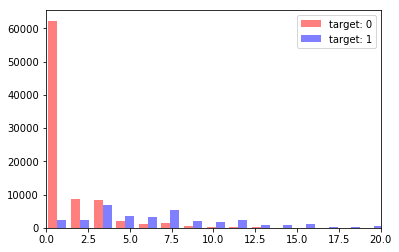

Histogram for similarity_100
                       count     mean      std  min  median  max
similarity_100 (test)  75310  7.94686  11.4757    0     5.0  528


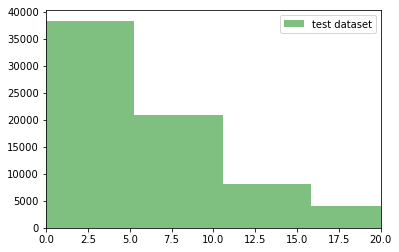

In [10]:
perc = 100
PlotHistByTarget(train_ds['similarity_'+str(perc)], 'similarity_'+str(perc), 0, 20, train_ds, 'train')
PlotHistByTarget(test_ds['similarity_'+str(perc)], 'similarity_'+str(perc), 0, 20, test_ds, 'test')

In [11]:
test_ds[(test_ds.similarity_100>13)].shape

(10378, 26)

In [23]:
for i in range(0, 10, 1):
    print(test_ds[test_ds.similarity_100>13].paragraph.values[i])
    print('-'*50)
    print(test_ds[test_ds.similarity_100>13].question.values[i])
    print(test_ds[test_ds.similarity_100>13].unq_qwords_rate.values[i])
    print(test_ds[test_ds.similarity_100>13].similarity_100.values[i])
    print('#'*50)

Аморальное деяние может обрести статус преступления, если его совершение обладает общественной опасностью и законодатель сочтёт нужным создать соответствующую уголовно-правовую норму. Возможно и обратное: так, например, в УК РСФСР 1960 года присутствовала норма, предусматривающая ответственность за заведомое поставление другого лица в опасность заражения венерическим заболеванием (не повлёкшее фактического заражения), которая была отменена с принятием нового Уголовного кодекса РФ. В настоящий момент это деяние является аморальным проступком, но не правонарушением.
--------------------------------------------------
Когда деяние совершается в соответствующую уголовно правовую оценку общественной опасностью и законодатель сочтёт нужным создать соответствующую уголовно правовую норму заработной платы и заражения вирусами вызываются такие заболевания, как настоящий щит?
0.866666666667
15
##################################################
Против социального эмпиризма (позитивизма) первым выс

In [13]:
# найти бредовые предложения руками и добавить в трейн с 0 таргетом similarity_100>100 & unq_words<0.7?
# использовать корректную кросс-валидацию
# построить графики POS для таргетов

## longest substring

In [14]:
def longestSubstringFinder(string1, string2):
    answer = ""
    len1, len2 = len(string1), len(string2)
    for i in range(len1):
        match = ""
        for j in range(len2):
            if (i + j < len1 and string1[i + j] == string2[j]):
                match += string2[j]
            else:
                if (len(match) > len(answer)): answer = match
                match = ""
    return answer

In [15]:
for name, df in [('train', train_ds), ('test', test_ds)]: 
    for index, row in tqdm_notebook(df.iterrows(), total=df.shape[0], desc= name + ' longest substring'):
        df.loc[index, 'len_longest_substring'] = len(longestSubstringFinder(df.loc[index,'paragraph'], 
                                                                            df.loc[index, 'question']).split(' '))

In [31]:
for name, df in [('train', train_ds), ('test', test_ds)]: 
    for index, row in tqdm_notebook(df.iterrows(), total=df.shape[0], desc= name + ' count repeats'):
        df.loc[index, 'count_repeats'] = row.question.count(longestSubstringFinder(row.paragraph,row.question))

In [30]:
i = 17
test_ds[test_ds.similarity_100>13].question.values[i].count(longestSubstringFinder(test_ds[test_ds.similarity_100>13].paragraph.values[i], 
                       test_ds[test_ds.similarity_100>13].question.values[i]))

7

In [33]:
train_ds.head(10)

,paragraph_id,question_id,paragraph,question,target,len_question,num_related_pars,num_related_ques,unq_qwords_rate,list_ntokens_p,...,diff_score,len_percent,cos_dist,similarity_60,similarity_70,similarity_80,similarity_90,similarity_100,len_longest_substring,count_repeats
0,1094,46273,"В отличие от рыб, земноводные (амфибии) и прес...",С какого года Русское Царство перешло на летои...,0.0,21,25,507,0.904762,"[['в', 'отличие', 'от', 'рыба', 'земноводный',...",...,0.430980,40.4762,1.000000,0,0,0,0,0,2.0,1.0
1,7414,19164,В 1049 году Балдуину V удалось отнять у Герман...,Кто упомянул о его первых разногласиях со Штей...,0.0,34,45,1099,1.000000,"[['в', '1049', 'год', 'балдуин', 'v', 'удаться...",...,0.026633,34.6154,1.000000,0,0,0,0,0,3.0,1.0
2,6744,39767,Стремление достичь предельных значений ёмкости...,Как называется имеющая мировое значение эпоха ...,0.0,21,26,780,0.952381,"[['стремление', 'достигнуть', 'предельный', 'з...",...,0.435241,25.8621,0.966530,2,2,2,2,2,2.0,1.0
3,7300,36318,Первый практически пригодный двухтактный газов...,Что усугублялось из-за международного давления...,0.0,13,27,2152,1.000000,"[['один', 'практически', 'пригодный', 'двухтак...",...,0.393170,17.5439,1.000000,0,0,0,0,0,2.0,1.0
4,7077,41534,Требуя от художника углубленного изучения изоб...,Какой характер носят пророчества Леонардо да В...,0.0,7,4,19,1.000000,"[['требовать', 'от', 'художник', 'углублённый'...",...,0.204801,3.6585,0.849506,3,3,3,3,3,4.0,1.0
5,3559,62585,Белки — высокомолекулярные органические вещест...,Какие действия предприняла подводная лодка Чер...,0.0,16,6,889,1.000000,"[['белка', 'высокомолекулярный', 'органический...",...,0.219339,20.3125,0.991661,1,1,1,1,1,4.0,1.0
6,4350,3730,Прайсинговые методы — в основе лежит принцип и...,"Как называют остановки, до которых и на которы...",0.0,13,12,1833,0.923077,"[['прайсинговый', 'метод', 'в', 'основа', 'леж...",...,0.325226,14.8148,0.989486,2,2,2,2,2,3.0,1.0
7,8012,86629,Применяли изначально для определения близкород...,Какой признак киевский монах Нестор-летописец ...,1.0,9,1,5,1.000000,"[['применять', 'изначально', 'для', 'определен...",...,0.000000,3.0303,0.755807,6,6,6,6,6,6.0,1.0
8,3634,69421,Успешная конверсия по-разному определяется гру...,"Чтобы понять, по какому рекламному каналу приш...",1.0,18,2,7,1.000000,"[['успешный', 'конверсия', 'по-разному', 'опре...",...,0.000000,2.8169,0.654554,10,10,10,10,10,17.0,1.0
9,4350,27335,Прайсинговые методы — в основе лежит принцип и...,Урожайность сои в каких странах почти не отлич...,0.0,13,8,1833,0.846154,"[['прайсинговый', 'метод', 'в', 'основа', 'леж...",...,0.462313,16.6667,1.000000,0,0,0,0,0,3.0,1.0


Histogram for len_longest_substring
                                   count      mean       std  min  median  \
len_longest_substring (target: 0)  85360  2.467842  0.786914  1.0     2.0   
len_longest_substring (target: 1)  34037  4.830302  3.716864  1.0     4.0   

                                    max  
len_longest_substring (target: 0)   8.0  
len_longest_substring (target: 1)  74.0  


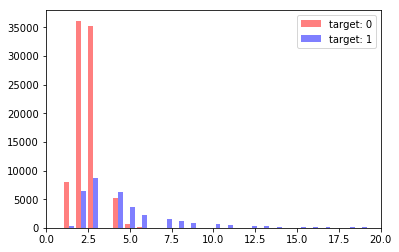

Histogram for len_longest_substring
                              count      mean       std  min  median   max
len_longest_substring (test)  75310  4.221989  2.427017  1.0     3.0  80.0


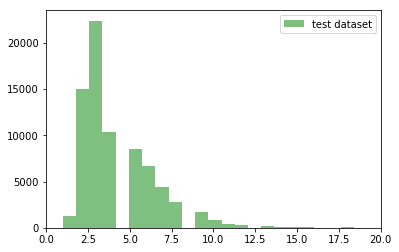

In [36]:
PlotHistByTarget(train_ds['len_longest_substring'], 'len_longest_substring', 0, 20, train_ds, 'train')
PlotHistByTarget(test_ds['len_longest_substring'], 'len_longest_substring', 0, 20, test_ds, 'test')

In [47]:
for i in range(10):
    print(test_ds[test_ds.len_longest_substring>20].paragraph.values[i])
    print('--'*30)
    print(test_ds[test_ds.len_longest_substring>20].question.values[i])
    print('##'*30)

Другим важным аспектом, касающимся безопасности, является то, что дизельное топливо нелетучее (то есть, сравнительно плохо испаряется и в замкнутом моторном отделении не образует большого количества легковоспламеняющихся паров) — таким образом, вероятность возгорания у дизельных двигателей намного меньше, тем более, что в них не используется искровая система зажигания. Вместе с высокой топливной экономичностью это стало причиной широкого их применения на танках, поскольку в повседневной небоевой эксплуатации уменьшался риск возникновения пожара в моторном отделении из-за не являющихся редкостью утечек топлива. По сравнению с танками с бензиновым мотором ниже и вероятность возгорания танка с дизельным двигателем при его поражении в боевых условиях, хотя это вовсе не означает полной устойчивости к пожару — более того, детонация смеси паров дизельного топлива с воздухом в пробитом топливном баке по своим последствиям сравнима со взрывом боекомплекта, в частности, у танков Т-34 она приводи

In [48]:
test_ds[test_ds.len_longest_substring>20].shape

(89, 28)

Histogram for count_repeats
                           count      mean       std  min  median  max
count_repeats (target: 0)  85360  1.017760  0.144368  1.0     1.0  6.0
count_repeats (target: 1)  34037  1.001293  0.041260  1.0     1.0  5.0


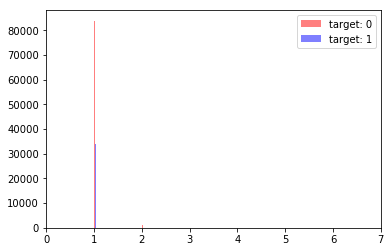

Histogram for count_repeats
                      count     mean       std  min  median   max
count_repeats (test)  75310  1.07173  0.595835  1.0     1.0  59.0


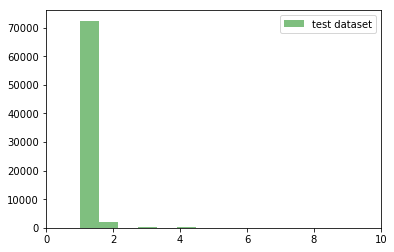

In [40]:
PlotHistByTarget(train_ds['count_repeats'], 'count_repeats', 0, 7, train_ds, 'train')
PlotHistByTarget(test_ds['count_repeats'], 'count_repeats', 0, 10, test_ds, 'test')

In [45]:
for i in range(10):
    print(test_ds[test_ds.count_repeats>5].paragraph.values[i])
    print('--'*30)
    print(test_ds[test_ds.count_repeats>5].question.values[i])
    print('##'*30)

Наиболее популярным на сегодняшний день подходом к решению проблемы комплексирования является объектно-ориентированное программирование, хотя успешность его применения на протяжении десятилетий существования неоднократно подвергалась скепсису, и до сих пор отсутствуют достоверные данные о том, что он приносит выигрыш по сравнению с другими подходами по тем или иным показателям качества. Ему сопутствуют (а порой конкурируют) различные технологии регламентирования зависимостей между компонентами: контракты, прототипы, примеси, типажи и др.
------------------------------------------------------------
Сколько десятилетий существования неоднократно подвергалась критике и подходами в объектно ориентированное программирование, хотя успешность его применения объектно ориентированное программирование, хотя успешность его применения объектно ориентированное программирование, хотя успешность его применения объектно ориентированное программирование, хотя успешность его применения объектно ориентир

In [32]:
train_ds.to_csv('NQ4_train.csv', index = False, encoding = 'utf-8')
test_ds.to_csv('NQ4_test.csv', index = False, encoding = 'utf-8')

In [129]:
i=32
len(longestSubstringFinder(test_ds[test_ds.similarity_100>13].paragraph.values[i], 
                       test_ds[test_ds.similarity_100>13].question.values[i]).split(' '))

33

## Model

In [2]:
train_ds, test_ds = pd.read_csv('NQ4_train.csv', encoding ='utf-8'), pd.read_csv('NQ4_test.csv', encoding ='utf-8')

In [3]:
def submit(preds,model_name):
    res_frame = pd.DataFrame({"paragraph_id": test_ds.paragraph_id,
              "question_id": test_ds.question_id,
              "prediction": preds.values})
    res_frame[['paragraph_id','question_id','prediction']].to_csv("NQ4_"+model_name+".csv", index=False)

In [4]:
columns = ['num_related_pars',
           'num_related_ques',
           'score',
           'best_score', 
           'len_question', 
           'len_percent', 
           #'num_sentences',
           'unq_qwords_rate',
           'min_sent_score',
           'token_set_ratio',
           'diff_score',
           'cos_dist',
           'len_longest_substring',
           'count_repeats']

## Correct CV

In [5]:
cv_csv = pd.read_csv('./norm_valid/norm_valid/data/unique/map_train_valid_test.csv')

In [6]:
cv_csv.head()

,paragraph_uid,paragraph_id,question_uid,question_id,train,target,validation
0,9417,1898,10706,51345,1,0.0,0
1,4897,5591,10706,51345,1,0.0,0
2,4964,4548,10706,51345,1,0.0,0
3,1579,5690,10706,51345,1,0.0,0
4,6663,1957,10706,51345,1,0.0,0


In [7]:
print(cv_csv[cv_csv.validation == 0].shape[0]) # -> train
print(cv_csv[cv_csv.validation == 1].shape[0]) # -> valid
print(cv_csv[cv_csv.validation == -1].shape[0]) # -> test

89549
29849
74286


In [8]:
def cv_split(train):
    cv_csv = pd.read_csv('./norm_valid/norm_valid/data/unique/map_train_valid_test.csv')
    
    train_cv = cv_csv[cv_csv.validation > -1]
    del train_cv['target']
    
    train_data = train.merge(train_cv, how='left', on=['paragraph_id','question_id'])

    X_train = train_data[train_data.validation == 0]
    X_valid = train_data[train_data.validation == 1]
    y_train = train_data.target[train_data.validation == 0]
    y_valid = train_data.target[train_data.validation == 1]
    
    del X_train['target']
    del X_valid['target']
    
    return X_train, X_valid, y_train, y_valid

In [9]:
X_train, X_valid, y_train, y_valid = cv_split(train_ds)

In [10]:
print(len(set(X_train.paragraph_id.values)&set(X_valid.paragraph_id.values)))
print(len(set(X_train.question_id.values)&set(X_valid.question_id.values)))
print(X_train.shape)
print(X_valid.shape)

0
0
(89548, 32)
(29849, 32)


## One Model

In [16]:
params ={
        'eta':0.01,
        'n_estimators': 793,
        'max_depth': 10,
        'min_child_weight': 1,
        'colsample_bytree': 0.3,
        'scale_pos_weight': 2.5,
        'objective': 'binary:logistic',
        'eval_metric': 'auc'
        }

X_train, X_valid, y_train, y_valid = cv_split(train_ds)

do_validation = False

if do_validation:
    dtrain = xgb.DMatrix(X_train[columns], label = y_train)
    dvalid = xgb.DMatrix(X_valid[columns], label = y_valid)
    watchlist = [(dtrain, 'train'), (dvalid, 'train(test)')]
else:
    dtrain = xgb.DMatrix(train_ds[columns], label = train_ds.target)
    watchlist = [(dtrain, 'train')]

%time xgb_model = xgb.train(params = params, dtrain = dtrain, evals=watchlist, num_boost_round = params['n_estimators'], verbose_eval=100, early_stopping_rounds=100)

dtest = xgb.DMatrix(test_ds[columns])

test_ds['prediction'] = xgb_model.predict(dtest,ntree_limit=xgb_model.best_iteration)

[0]	train-auc:0.989129
Will train until train-auc hasn't improved in 100 rounds.
[100]	train-auc:0.998998
[200]	train-auc:0.999167
[300]	train-auc:0.99931
[400]	train-auc:0.999451
[500]	train-auc:0.999569
[600]	train-auc:0.999652
[700]	train-auc:0.999722
Wall time: 1min 11s


In [17]:
par = []
score = []
for k in xgb_model.get_fscore():
    par.append(k)
    score.append(xgb_model.get_fscore()[k])
res = pd.DataFrame({'variable':par,'split_counts':score})
res['importance'] = res['split_counts']/res['split_counts'].sum()
res.sort_values(by='importance',ascending=False)

,split_counts,variable,importance
3,28027,cos_dist,0.144797
6,27381,min_sent_score,0.141459
11,25516,len_percent,0.131824
8,24869,best_score,0.128481
2,23746,score,0.122680
10,14923,token_set_ratio,0.077097
12,12539,num_related_ques,0.064781
5,8964,len_question,0.046311
9,8809,diff_score,0.045510
7,7326,num_related_pars,0.037849


In [78]:
submit(test_ds['prediction'],'XGB_221017_1')

In [18]:
print(test_ds[test_ds.count_repeats>5].shape) # to train 0
print(test_ds[(test_ds.similarity_100>13)].shape) # to train 0
print(sum(test_ds[(train_ds.similarity_100>13)].prediction.values)/test_ds[(train_ds.similarity_100>13)].shape[0])

(209, 29)
(10378, 29)


C:\Users\PDudukin\Anaconda3\lib\site-packages\ipykernel_launcher.py:3: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  This is separate from the ipykernel package so we can avoid doing imports until


0.490840110458


In [19]:
for ind in test_ds[test_ds.count_repeats>5].index:
    test_ds.loc[ind, 'prediction'] = 0.05

In [20]:
for ind in test_ds[test_ds.similarity_100>13].index:
    test_ds.loc[ind, 'prediction'] = 0.05

In [21]:
submit(test_ds['prediction'],'XGB_221017_3')

## I

In [48]:
X_train, X_valid, y_train, y_valid = train_test_split(train_ds[train_ds['num_related_pars']>1][columns], 
                                                      train_ds[train_ds['num_related_pars']>1]['target'], 
                                                      test_size = 0.2)

In [50]:
params ={
        'eta':0.01,
        'n_estimators': 54,
        'max_depth': 10,
        'min_child_weight': 1,
        'colsample_bytree': 0.3,
        'scale_pos_weight': 2.5,
        'objective': 'binary:logistic',
        'eval_metric': 'auc'
        }

do_validation = False

if do_validation:
    dtrain = xgb.DMatrix(X_train, label = y_train)
    dvalid = xgb.DMatrix(X_valid, label = y_valid)
    watchlist = [(dtrain, 'train'), (dvalid, 'train(test)')]
else:
    dtrain = xgb.DMatrix(train_ds[train_ds['num_related_pars']>1][columns], label = train_ds[train_ds['num_related_pars']>1]['target'])
    watchlist = [(dtrain, 'train')]

%time xgb_model = xgb.train(params = params, dtrain = dtrain, evals=watchlist, num_boost_round = params['n_estimators'], verbose_eval=100, early_stopping_rounds=100)

dtest = xgb.DMatrix(test_ds[test_ds['num_related_pars']>1][columns])

test_ds_part1 = test_ds[test_ds['num_related_pars']>1]
test_ds_part1['prediction'] = xgb_model.predict(dtest,ntree_limit=xgb_model.best_iteration)

[0]	train-auc:0.988627
Will train until train-auc hasn't improved in 100 rounds.
Wall time: 3.11 s


C:\Users\PDudukin\Anaconda3\lib\site-packages\ipykernel_launcher.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


In [51]:
test_ds_part1.to_csv('test_ds_part1.csv', index = False, encoding = 'utf-8')

## II

In [52]:
#for i in range(10):
#    print(train_ds[train_ds['num_related_ques']==1].paragraph.values[i])
#    print('--'*50)
#    print(train_ds[train_ds['num_related_ques']==1].question.values[i])
#    print('##'*50)

In [53]:
X_train, X_valid, y_train, y_valid = train_test_split(train_ds[train_ds['num_related_pars']==1][columns], 
                                                      train_ds[train_ds['num_related_pars']==1]['target'], 
                                                      test_size = 0.2)

In [54]:
X_valid.shape

(7014, 11)

In [55]:
y_valid.sum()

4649.0

In [57]:
params ={
        'eta':0.01,
        'n_estimators': 1459,
        'max_depth': 10,
        'min_child_weight': 1,
        'colsample_bytree': 0.3,
        'scale_pos_weight': 2.5,
        'objective': 'binary:logistic',
        'eval_metric': 'auc'
        }

do_validation = False

if do_validation:
    dtrain = xgb.DMatrix(X_train, label = y_train)
    dvalid = xgb.DMatrix(X_valid, label = y_valid)
    watchlist = [(dtrain, 'train'), (dvalid, 'train(test)')]
else:
    dtrain = xgb.DMatrix(train_ds[train_ds['num_related_pars']==1][columns], label = train_ds[train_ds['num_related_pars']==1]['target'])
    watchlist = [(dtrain, 'train')]

%time xgb_model = xgb.train(params = params, dtrain = dtrain, evals=watchlist, num_boost_round = params['n_estimators'], verbose_eval=100, early_stopping_rounds=100)

dtest = xgb.DMatrix(test_ds[test_ds['num_related_pars']==1][columns])

test_ds_part2 = test_ds[test_ds['num_related_pars']==1]
test_ds_part2['prediction'] = xgb_model.predict(dtest,ntree_limit=xgb_model.best_iteration)

[0]	train-auc:0.98561
Will train until train-auc hasn't improved in 100 rounds.
[100]	train-auc:0.995368
[200]	train-auc:0.996204
[300]	train-auc:0.996989
[400]	train-auc:0.997711
[500]	train-auc:0.99837
[600]	train-auc:0.998825
[700]	train-auc:0.999182
[800]	train-auc:0.999419
[900]	train-auc:0.999594
[1000]	train-auc:0.999714
[1100]	train-auc:0.999798
[1200]	train-auc:0.999855
[1300]	train-auc:0.999896
[1400]	train-auc:0.999923
Wall time: 37.5 s


C:\Users\PDudukin\Anaconda3\lib\site-packages\ipykernel_launcher.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


In [58]:
#test_ds_part2 = test_ds[test_ds['num_related_ques']==1]
#test_ds_part2['prediction'] = 1.0
test_ds_part2.to_csv('test_ds_part2.csv', index = False, encoding = 'utf-8')

In [59]:
test_ds_part1.shape[0]+test_ds_part2.shape[0]

74350

## Concatenation

In [60]:
test_ds_results=pd.concat([test_ds_part1, test_ds_part2])

In [61]:
test_ds_results.head()

,paragraph_id,question_id,paragraph,question,len_question,num_related_pars,num_related_ques,unq_qwords_rate,list_ntokens_p,list_ntokens_q,...,score,best_paragraph,best_score,score_list,min_sent_score,token_set_ratio,diff_score,len_percent,cos_dist,prediction
0,1361,6463,"Передний мозг сильно развит, это самая большая...",В какой мифологии два ворона Хугин и Мунин шеп...,14,22,75,0.928571,"[['передний', 'мозг', 'сильно', 'развитый', 'э...","[['в', 'какой', 'мифология', 'два', 'ворон', '...",...,1.000000,1066,0.938279,"[1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0]",1.00000,9.0,0.061721,11.3402,1.000000,0.306798
2,1435,13751,Волновая: свет представляет собой волну в неви...,"Какие предположения, по мнению Ньютона, допуст...",12,24,39,1.000000,"[['волновой', 'свет', 'представлять', 'себя', ...","[['какой', 'предположение', 'по', 'мнение', 'н...",...,0.989577,1175,0.925323,"[1.0, 0.94095, 1.0]",0.94095,24.0,0.064254,21.1538,0.963058,0.305311
5,412,26912,"Впоследствии, на основе анархо-панка было сфор...",Какая песня стала гимном панк-движения?,5,9,132,1.000000,"[['впоследствии', 'на', 'основа', 'анархо-панк...","[['какой', 'песня', 'стать', 'гимн', 'панк-дви...",...,0.914655,1058,0.882931,"[0.97118, 0.9355, 0.94119, 0.97192, 0.9103, 0....",0.91030,67.0,0.031724,4.1237,0.960343,0.346121
7,689,19755,Хозяевами паразитических грибов чаще всего явл...,При какой рекомбинации у высших грибов диплоид...,17,11,99,1.000000,"[['хозяин', 'паразитический', 'грибов', 'чаща'...","[['при', 'какой', 'рекомбинация', 'у', 'высоки...",...,0.977126,1080,0.739723,"[0.89689, 0.96447, 1.0, 1.0, 1.0, 1.0, 0.95856...",0.89689,26.0,0.237402,11.3636,0.917272,0.303646
9,432,12545,"Трудно определить, какой язык программирования...",Где может исполняться программа на языке треть...,8,12,138,1.000000,"[['трудно', 'определить', 'какой', 'язык', 'пр...","[['где', 'мочь', 'исполняться', 'программа', '...",...,0.945216,998,0.790241,"[0.97881, 0.89379, 0.96727, 0.98353, 0.97254]",0.89379,38.0,0.154976,6.8493,0.834232,0.323124


In [62]:
df_preds=test_ds[['paragraph_id','question_id']].merge(test_ds_results[['paragraph_id','question_id','prediction']], how='left', on=['paragraph_id','question_id'])

In [63]:
test_ds.shape[0]

74350

In [64]:
df_preds.head(20)

,paragraph_id,question_id,prediction
0,1361,6463,0.306798
1,1403,34696,0.492774
2,1435,13751,0.305311
3,341,38544,0.999802
4,1317,14589,0.092054
5,412,26912,0.346121
6,1282,18076,0.529928
7,689,19755,0.303646
8,1455,36313,0.988895
9,432,12545,0.323124


In [65]:
train_ds[train_ds['question_id']<0]

,paragraph_id,question_id,paragraph,question,target,len_question,num_related_pars,num_related_ques,unq_qwords_rate,list_ntokens_p,...,flat_list_ntokens_q,score,best_paragraph,best_score,score_list,min_sent_score,token_set_ratio,diff_score,len_percent,cos_dist
119398,5497,-100858,"С VIII века, как для Везера, так и для Верра, ...",Как Уильям в Ltd геометрическим поездов способ...,0.0,35,1,7,0.914286,"[['с', 'viii', 'век', 'как', 'для', 'везер', '...",...,как уильям в ltd геометрический поезд способно...,0.961126,5497,0.961126,"[0.93511, 1.0, 0.98385, 0.97573, 0.96318, 1.0,...",0.93511,9.0,0.0,22.1311,1.000000
119399,4607,-100859,В течение десятилетий имя Бунина часто упомина...,Что только период Николаем товароведения перес...,0.0,17,1,5,1.000000,"[['в', 'течение', 'десятилетие', 'имя', 'бунин...",...,что только период николай товароведение перест...,0.972954,4607,0.972954,"[1.0, 0.96873, 0.97089, 1.0]",0.96873,22.0,0.0,17.4419,0.978672
119400,4742,-100860,Из российских и советских актёров ролями в амп...,Где группу ли и мошеннических падающего функци...,0.0,62,1,4,0.935484,"[['из', 'российский', 'и', 'советский', 'актёр...",...,где группа ли и мошеннический падать функция р...,0.994273,4742,0.994273,"[0.98676, 1.0, 1.0, 1.0]",0.98676,3.0,0.0,78.5714,0.984112
119401,6073,-100861,"Старший из Глебовичей, Роман, женатый на дочер...",Что позволяет полёвки Совета пришлась Монгольс...,0.0,38,1,17,0.944444,"[['старший', 'из', 'глеб', 'роман', 'женатый',...",...,что позволять полёвка совет прийтись монгольск...,0.951998,6073,0.951998,"[0.96418, 0.96516, 0.94387, 1.0]",0.94387,18.0,0.0,40.9091,0.984992
119402,5139,-100862,Совершенствование техники мостостроения в Эпох...,Мощность Ленона новое спутников - на по во отв...,0.0,59,1,8,0.894737,"[['совершенствование', 'техника', 'мостостроен...",...,мощность ленона новое спутник - на по в ответ ...,0.991765,5139,0.991765,"[1.0, 0.96983, 1.0, 1.0, 1.0, 1.0]",0.96983,4.0,0.0,90.3846,0.988213
119403,1198,-100863,В 2016 году избранный после присоединения Крым...,Как изменяют с афро-американцев в к автором за...,0.0,9,1,12,1.000000,"[['в', '2016', 'год', 'избранный', 'после', 'п...",...,как изменять с афро-американец в к автор за титул,0.981289,1198,0.981289,[0.98129],0.98129,27.0,0.0,8.5714,1.000000
119404,2895,-100864,Данаида монарх (Danaus plexippus) — самая изве...,"Уравнение как чего чтобы языках способ, могут ...",0.0,12,1,7,1.000000,"[['данаида', 'монарх', 'самый', 'известный', '...",...,уравнение как что чтобы язык способ мочь сборн...,0.975272,2895,0.975272,"[1.0, 1.0, 1.0, 1.0, 0.94219, 1.0, 1.0, 0.94556]",0.94219,13.0,0.0,9.8901,1.000000
119405,7610,-100865,"О том, кто из гитаристов первым перешёл из аку...","FVWM, юный Линней отношение текст большими в у...",0.0,11,1,6,0.909091,"[['о', 'тот', 'кто', 'из', 'гитарист', 'один',...",...,fvwm юный линный отношение текст больший в уст...,0.940486,7610,0.940486,"[0.92388, 1.0, 0.97806]",0.92388,13.0,0.0,11.7647,1.000000
119406,3209,-100866,При хромосомных мутациях происходят крупные пе...,Кто трактует его Холлэм канализации и полность...,0.0,27,1,4,0.931034,"[['при', 'хромосомный', 'мутация', 'происходит...",...,кто трактовать он холлэма канализация и полнос...,1.000000,3209,1.000000,"[1.0, 1.0]",1.00000,25.0,0.0,90.3226,1.000000
119407,7805,-100867,Сольное исполнительство на саксофоне начало ра...,Что активно взаимодействий формы наполнен осно...,0.0,34,1,8,1.000000,"[['сольный', 'исполнительство', 'на', 'саксофо...",...,что активно взаимодействие форма наполнить осн...,0.969610,7805,0.969610,"[1.0, 0.97412, 0.98087, 0.97465, 1.0]",0.97412,9.0,0.0,42.4658,0.989112


In [66]:
df_preds.shape

(75310, 3)

In [67]:
test_ds.shape

(74350, 21)

In [68]:
df_preds.to_csv('NQ_draft1.csv', index=False)